<a href="https://colab.research.google.com/github/looee1q/PracticalML/blob/7.4-roc-auc/SVM_task_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVM. Метод опорных векторов + Кросс-валидация

В этом задании вы попрактикуетесь в применении метода опорных векторов, а также примените кросс-валидацию для подбора гиперпараметров и оценки качества моделей!

## Данные

В этой практической работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры и сравнивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - `age`
 - `workclass`
 - `fnlwgt`
 - `education`
 - `education-num`
 - `marital-status`
 - `occupation`
 - `relationship`
 - `race`
 - `sex`
 - `capital-gain`
 - `capital-loss`
 - `hours-per-week`

Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Бонус ноутбука

Все исследователи данных знают, что SVM из библиотеки `sklearn` работает крайне медленно, поэтому на практике не могут его применять для решения задач.

В этом ноутбуке мы используем средства библиотеки `sklearn intelex` для ускорения обучения SVM в 600 раз!

Ради интереса попробуйте после завершения выполнения заданий в ноутбуке удалить ячейки, связанные с установкой и импортом `sklearn intelex` и засечь время работы методов :)

In [1]:
!python --version

Python 3.11.12


In [2]:
%%capture
!python -m pip install --upgrade pip
!pip install --upgrade scikit-learn-intelex

In [3]:
from sklearnex import patch_sklearn
patch_sklearn()

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [4]:
import pandas as pd
import numpy as np
import sys
import os
import site

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from matplotlib import pyplot as plt

sys.path.append(os.path.join(os.path.dirname(site.getsitepackages()[0]), "site-packages"))

In [5]:
site.getsitepackages()

['/usr/local/lib/python3.11/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/lib/python3.11/dist-packages']

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики *AUC-ROC*.

Загрузим набор данных `data.adult.csv`.

In [6]:
df = pd.read_csv("https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/data.adult.csv")

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


In [7]:
df.describe(include='all')

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
count,16280.000000,16280,1.628000e+04,16280,16280.000000,16280,16280,16280,16280,16280,16280.000000,16280.000000,16280.000000,16280
unique,NaN,9,NaN,16,NaN,7,15,6,5,2,NaN,NaN,NaN,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,<=50K
freq,NaN,11282,NaN,5214,NaN,7552,2095,6618,13912,10919,NaN,NaN,NaN,12244
mean,38.635074,NaN,1.894594e+05,NaN,10.098219,NaN,NaN,NaN,NaN,NaN,1020.417752,86.696314,40.403686,NaN
std,13.635301,NaN,1.066644e+05,NaN,2.567690,NaN,NaN,NaN,NaN,NaN,6862.041550,402.308715,12.341191,NaN
min,17.000000,NaN,1.930200e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN
25%,28.000000,NaN,1.170068e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN
50%,37.000000,NaN,1.781340e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN
75%,48.000000,NaN,2.371630e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN


Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение `numpy.nan`.  
Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html).

В данном датасете пропущенные значения обозначены как "?".

### Задание

Найдите все признаки, имеющие пропущенные значения.

Затем удалите из выборки все объекты с пропусками.

In [8]:
for column in df.columns:
  df[column] = df[column].replace("?", np.nan)

In [9]:
df.isna().sum()

,0
age,0
workclass,929
fnlwgt,0
education,0
education-num,0
marital-status,0
occupation,933
relationship,0
race,0
sex,0


In [10]:
df.shape

(16280, 14)

In [11]:
df.dropna(inplace=True)

In [12]:
df.shape

(15347, 14)

Обычно после загрузки датасета всегда необходима его некоторая предобработка.  
В данном случае она будет заключаться в следующем:

 - Выделите целевую переменную y в отдельную переменную и преобразуйте к бинарному формату по правилу:  
 '>50K' - 1, '<=50K' - 0.
 - Выделите матрицу объект-признак `X`, содержащую только вещественные столбцы (числовые) и не содержащую целевой переменной
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [13]:
y = df['>50K,<=50K'].map({"<=50K": 0, ">50K": 1})

In [14]:
X = df.drop('>50K,<=50K', axis=1)

In [15]:
categoral_columns = X.describe(include='object').columns
X_num_only = X.drop(columns=categoral_columns)

### Задание

Cколько столбцов содержит матрица `X`?

In [16]:
X_num_only.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40


Постройте гистограммы для признаков `age`, `fnlwgt`, `capital-gain`. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

Ответьте на этот вопрос для себя устно.

<Axes: xlabel='age', ylabel='Frequency'>

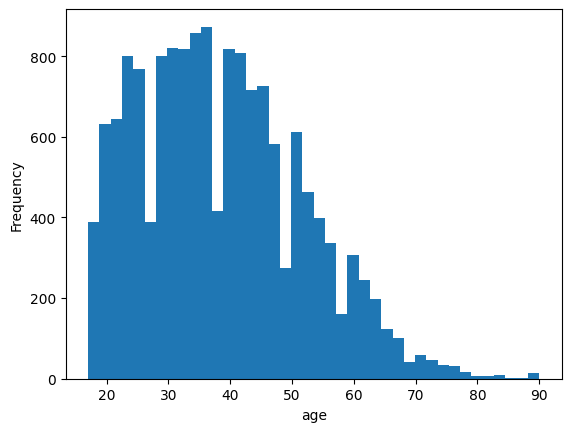

In [17]:
X_num_only["age"].plot.hist(bins=40, xlabel="age")

<Axes: xlabel='fnlwgt', ylabel='Frequency'>

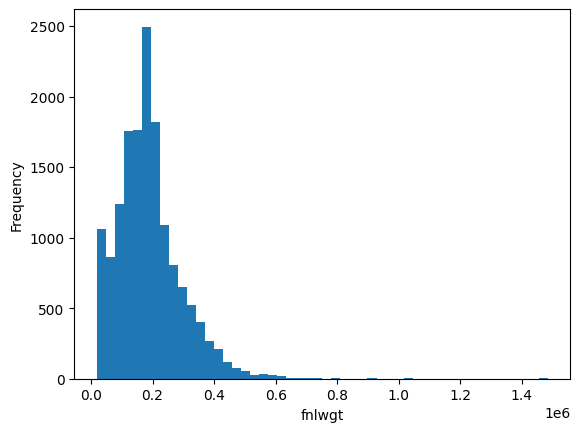

In [18]:
X_num_only["fnlwgt"].plot.hist(bins=50, xlabel="fnlwgt")

<Axes: xlabel='capital-gain', ylabel='Frequency'>

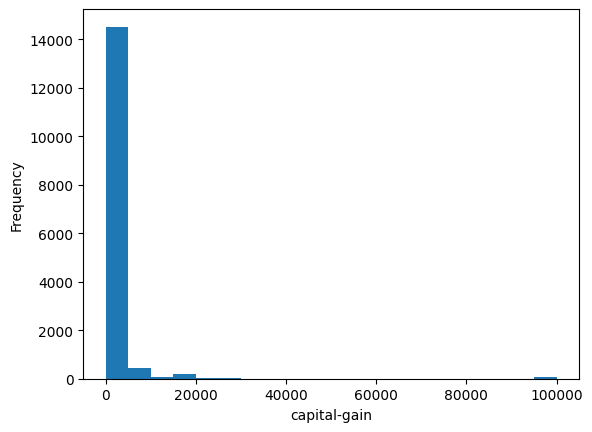

In [19]:
X_num_only["capital-gain"].plot.hist(bins=20, xlabel="capital-gain")

Масштабируйте все вещественные признаки (масштабированную матрицу назовите, как и раньше, `X`).

In [21]:
from sklearn.preprocessing import StandardScaler

standart_scaler = StandardScaler()
X_num_only = standart_scaler.fit_transform(X_num_only)

## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В этом задании необходимо проверять качество алгоритмов по кросс-валидации. Напомним, что это за процесс.


### Кросс-валидация [обучающий текст]

Разбивать данные на train-test как мы делали раньше - неплохой подход. Однако при этом подходе мы привязываем и обучение модели, и оценку качества к конкретному разбиению, а для другого разбиения можем получить модель совершенно другого качества, что плохо.

Поэтому хочется оценить качество модели без привязки к конкретному разбиению на train-test. Для этого все обучающие данные разбиваются на несколько равных блоков (фолдов), и затем модель обучается несколько раз:
* первый раз - на всех блоках, кроме 1-го, а качество оценивается на 1-м блоке
* второй раз - на всех блоках, кроме 2-го, а качество оценивается на 2-м блоке и так далее
Для оценки качества модели полученные значения метрик на тестовых блоках усредняются - это называется *k-fold кросс-валидацией*.

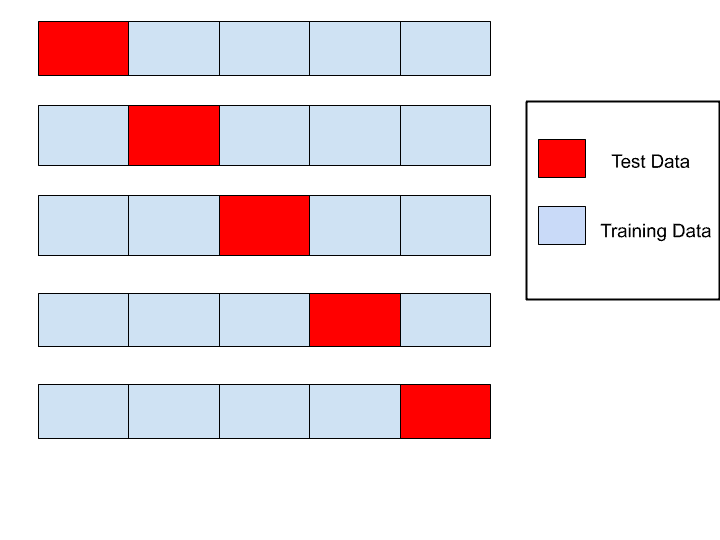

Сначала обучите по кросс-валидации c **тремя** фолдами и метрикой **roc_auc** алгоритмы:
*  LogisticRegression
*  SVC(kernel='linear')

Остальные параметры оставьте по умолчанию.

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# пример для логистической регрессии

cross_val_score(LogisticRegression(), X_num_only, y, cv=3, scoring='roc_auc', verbose=2).mean()

[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s finished


np.float64(0.825026286490548)

In [23]:
# посмотрите на среднее качество SVM с линейным ядром

cross_val_score(SVC(kernel="linear"), X_num_only, y, cv = 3, scoring='roc_auc', verbose=2).mean()

[CV] END .................................................... total time=   2.7s
[CV] END .................................................... total time=   2.9s
[CV] END .................................................... total time=   1.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.3s finished


np.float64(0.8075427740991511)

### Задание

Чему равно качество наилучшей из этих моделей?  
Ответ округлите до десятых.

Теперь посмотрим как влияет подбор гиперпараметров на качество предсказания моделей. Сейчас и далее будем рассматривать два алгоритма:
 - Logistic Regression
 - SVC (Support Vector Classifier)

У обоих алгоритмов будем оптимизировать гиперпараметр С, а у SVC - ещё гиперпараметр kernel.

*  Ищите C в диапазоне от 0.01 до 10.01 с шагом 0.25
*  Перебирайте ядра из списка ['rbf','poly','sigmoid','linear']

### Подбор гиперпараметров по сетке (GridSearchCV) [обучающий текст]

Раз уж мы начали использовать кросс-валидацию, то будем использовать ее по-максимуму. Для подбора гиперпараметров модели также можно применить этот подход вместо разбиения на train и test.

Идея подбора гиперпараметров по сетке:

* задаем список перебираемых значений гиперпараметров (можно подбирать одновременно несколько гиперпараметров)

* для каждого набора значений гиперпараметров вычисляем качество модели по кросс-валидации

* итоговый ответ - это набор значений гиперпараметров, для которого модель имеет наибольшее качество на кросс-валидации.

Метод, реализующий эту схему, называется GridSearchCV.

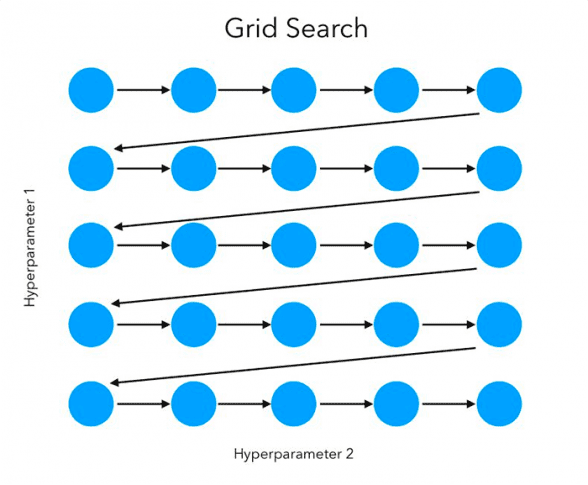

Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе GridSearchCV. В качестве схемы кросс-валидации используйте 3-fold cv.

Покажем пример использования GridSearchCV.

In [25]:
# подберите C у логистической регрессии

from sklearn.model_selection import GridSearchCV

params = {'C' : [1, 2, 3]} # задаем словарь параметров и список перебираемых значений - в данном случае ищем C из списка [1,2,3]

gs = GridSearchCV(LogisticRegression(), params, cv=3, scoring='roc_auc')
# первый параметр - модель, второй - словарь параметров, третий - число фолдов, четвертый - метрика

gs.fit(X_num_only, y) # применяем метод к данным X, y (GridSearchCV сам разобъет данные на фолды)

print(gs.best_score_) # качество наилучшей модели (с оптимальными гиперпараметрами)
print(gs.best_params_) # оптимальные гиперпараметры

0.825026286490548
{'C': 1}


In [48]:
grid_search_cv_kernel = GridSearchCV(SVC(), param_grid={'kernel': ['rbf','poly','sigmoid','linear']}, cv=3, scoring='roc_auc')
grid_search_cv_kernel.fit(X_num_only, y)

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             scoring='roc_auc')

In [49]:
grid_search_cv_kernel.best_params_

{'kernel': 'linear'}

In [58]:
grid_search_cv_kernel.best_score_

np.float64(0.8075427740991511)

In [50]:
param_C = np.arange(0.01, 2.01 + 0.25, 0.25)

In [51]:
param_C

array([0.01, 0.26, 0.51, 0.76, 1.01, 1.26, 1.51, 1.76, 2.01])

In [52]:
# так как SVM работает долго, то:
# сначала первым gridsearch подберите у метода только kernel
# вторым gridsearch для найденного ядра подберите C в диапазане от 0.01 до 2.01 с шагом 0.25

grid_search_cv_param_C = GridSearchCV(SVC(kernel='linear'), param_grid={'C': param_C}, cv=3, scoring='roc_auc')
grid_search_cv_param_C.fit(X_num_only, y)

GridSearchCV(cv=3, estimator=SVC(kernel='linear'),
             param_grid={'C': array([0.01, 0.26, 0.51, 0.76, 1.01, 1.26, 1.51, 1.76, 2.01])},
             scoring='roc_auc')

In [53]:
grid_search_cv_param_C.best_params_

{'C': np.float64(0.01)}

In [57]:
grid_search_cv_param_C.best_score_

np.float64(0.8117119347552277)

In [54]:
grid_search_cv_kernel_and_param_C = GridSearchCV(SVC(), param_grid={'kernel': ['rbf','poly','sigmoid','linear'], 'C': param_C}, cv=3, scoring='roc_auc')
grid_search_cv_kernel_and_param_C.fit(X_num_only, y)

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': array([0.01, 0.26, 0.51, 0.76, 1.01, 1.26, 1.51, 1.76, 2.01]),
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             scoring='roc_auc')

In [55]:
grid_search_cv_kernel_and_param_C.best_params_

{'C': np.float64(0.01), 'kernel': 'rbf'}

In [56]:
grid_search_cv_kernel_and_param_C.best_score_

np.float64(0.8144803219219714)

### Задание

Какой из алгоритмов имеет наилучшее качество?

Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков.

*  Преобразуйте все категориальные признаки (исходной матрицы df) с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [`pandas.get_dummies`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html). Чтобы избежать переобучения, в `get_dummies` поставьте гиперпараметр **`drop_first=True`**.

*  Заново масштабируйте данные

In [64]:
X_old = df.drop('>50K,<=50K', axis=1)

In [65]:
X_new = pd.get_dummies(data = X_old, drop_first=True)

In [66]:
scaller_new = StandardScaler()
X_new = pd.DataFrame(scaller_new.fit_transform(X_new), columns=X_new.columns)

In [67]:
X_new.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,-0.342919,0.900258,-0.450788,-0.065600,-0.21874,1.588223,3.658322,-1.665953,-0.194785,-0.307272,...,1.711163,-0.175191,-0.416530,-0.338654,-0.227941,-0.182943,3.101735,-0.08727,-2.443271,0.686401
1,0.114760,0.010683,-0.059086,-0.150439,-0.21874,-0.074178,-0.273349,0.600257,-0.194785,-0.307272,...,1.711163,-0.175191,-0.416530,-0.338654,-0.227941,-0.182943,-0.322400,-0.08727,0.409287,0.686401
2,-0.190359,-0.106280,1.116020,-0.150439,-0.21874,-0.074178,3.658322,-1.665953,-0.194785,-0.307272,...,-0.584398,-0.175191,2.400786,-0.338654,-0.227941,-0.182943,-0.322400,-0.08727,0.409287,0.686401
3,-1.258276,-0.041382,-0.059086,-0.150439,-0.21874,-0.905379,-0.273349,0.600257,-0.194785,-0.307272,...,-0.584398,-0.175191,2.400786,-0.338654,-0.227941,-0.182943,-0.322400,-0.08727,0.409287,-1.456874
4,0.648719,-0.371197,1.116020,1.995391,-0.21874,-0.074178,-0.273349,0.600257,-0.194785,-0.307272,...,-0.584398,-0.175191,-0.416530,-0.338654,-0.227941,-0.182943,-0.322400,-0.08727,0.409287,0.686401


Так как после кодирования признаков получилось достаточно много, в этой работе мы не будем добавлять их и подбирать заново оптимальные гиперпараметры.

Обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 3-Fold CV в функции `cross_val_score`.

In [70]:
cross_val_score(SVC(kernel='rbf', C=0.01), X_new, y, cv=3, scoring='roc_auc').mean()

np.float64(0.8762295755248912)

In [72]:
cross_val_score(LogisticRegression(max_iter=1000), X_new, y, cv=3, scoring='roc_auc').mean()

np.float64(0.9021892516049101)

Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

### Задание

*  Разбейте данные на тренировочную и тестовую часть (либо данные только с числовыми признаками, либо данные после OneHot-кодировки - в зависимости от того, на каких данных модели лучше отработали).

**Вопрос:**  
стали ли модели лучше решать задачу при добавлении закодированных категориальных признаков?

*test_size = 0.25, random_state = 42*

* Cреди всех обученных в работе моделей возьмите наилучшую (по roc-auc).
Заново обучите эту модель на тренировочных данных, сделайте предсказание на тесте.

* Постройте roc-кривую и отметьте на ней значение roc-auc - по тестовым данным.

In [73]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.25, random_state=42)

In [85]:
scaller_new_2 = StandardScaler()
X_train = pd.DataFrame(scaller_new.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaller_new.fit_transform(X_test), columns=X_test.columns)

In [93]:
logistic_regression_best = LogisticRegression(max_iter=500)
logistic_regression_best.fit(X_train, y_train)
y_predict = logistic_regression_best.predict_proba(X_test)[:, 1]

In [94]:
y_predict

array([0.04303545, 0.05024091, 0.71346639, ..., 0.20310975, 0.03442518,
       0.00424163])

In [95]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test, y_predict)
roc_auc_best = auc(fpr, tpr)

### Задание

Чему равен `roc-auc` наилучшей модели на тестовых данных?

In [96]:
roc_auc_best

np.float64(0.9051020408163265)

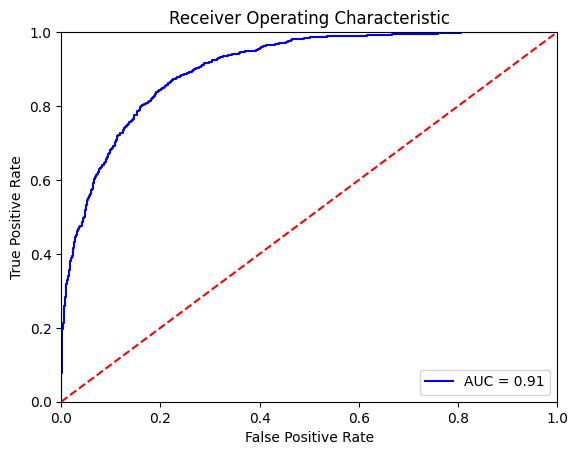

In [97]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = f'AUC = {roc_auc_best:.2f}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();